In [64]:
# 모듈로딩
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchmetrics.functional.classification as metrics
import sklearn.metrics as skm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [65]:
featureDF = pd.read_pickle('./DATA/feature2.pkl')
targetDF = pd.read_pickle('./DATA/target2.pkl')

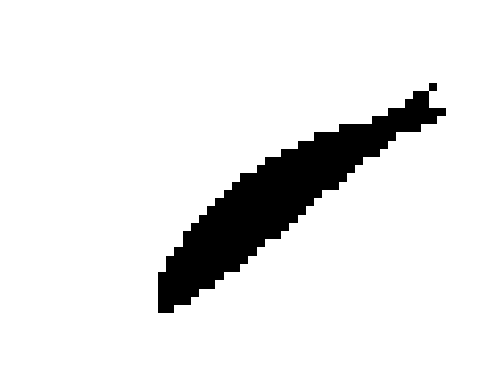

In [66]:
def plot_fish(image_data):
    image = image_data.reshape(45, 59)
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')

some_fish = featureDF.iloc[0].values
plot_fish(some_fish)
plt.show()

In [67]:
some_fish.shape

(2655,)

In [68]:
# 학습을 위해 타겟 데이터를 시리즈로 변경
targetSR = targetDF.squeeze()
type(targetSR)

pandas.core.series.Series

In [69]:
# shape 확인
print(f'featureDF => {featureDF.shape}, targetSR => {targetSR.shape}')

featureDF => (9000, 2655), targetSR => (9000,)


In [70]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 90, random_state = 42, stratify = targetSR)

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 810, random_state = 42, stratify = y_train)

In [72]:
# 데이터의 Tensor 변환
class DLDataset(Dataset):

    # 초기화 콜백 함수(callback function)
    def __init__(self, x_data, y_data):
        super().__init__()
        # x, y 데이터 => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.Series) else y_data

        # ndarray => tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)  # 타겟을 원핫인코딩하면 FloatTensor 사용
        print('[target & target shape]', self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 콜백 함수(callback function)
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수(callback function)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [73]:
trainDS = DLDataset(X_train, y_train)
validDS = DLDataset(X_val, y_val)
testDS = DLDataset(X_test, y_test)

[target & target shape] torch.Size([8100]) 1
[target & target shape] torch.Size([810]) 1
[target & target shape] torch.Size([90]) 1


In [74]:
validDS.feature.shape

torch.Size([810, 2655])

In [75]:
batch_size = 50
trainDL = DataLoader(trainDS, batch_size = batch_size, shuffle = True, drop_last = True)
validDL = DataLoader(validDS, batch_size = batch_size, shuffle = True, drop_last = True)
testDL = DataLoader(testDS, batch_size = batch_size, shuffle = True, drop_last = True)

In [76]:
len(trainDL), len(validDL), len(testDL)

(162, 16, 1)

In [77]:
# Epoch당 반복 단위
print(f'batch_size = {batch_size}')
print(f'trainDL => {len(trainDL)}개, validDL => {len(validDL)}개, testDL => {len(testDL)}개')

batch_size = 50
trainDL => 162개, validDL => 16개, testDL => 1개


In [78]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = 9

In [79]:
# 모델 인스턴스
IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
print(f'IN : {IN_DIM}, OUT : {OUT_DIM}')

IN : 2655, OUT : 9


### Dropout 적용, Weight Initialization 적용 <hr>

#### He Initialization

In [80]:
class FishModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, nodes_list = []):
        super().__init__()
        nodes_list.insert(0, in_dim)
        nodes_list.append(out_dim)
        layer_num = len(nodes_list) - 1
        layers = []
        for i in range(layer_num):
            if i <= layer_num - 2:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
                layers.append(nn.BatchNorm1d(num_features = nodes_list[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout())    
            else:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
        
        self.layers = nn.ModuleList(layers)

        nn.init.kaiming_normal_(self.layers[0].weight)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [81]:
### ===> 학습 진행함수 
def training(epoch):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], [], []]
    for idx, (feature, target)  in enumerate(trainDL):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_traget = model(feature)
        
        # 손실계산
        loss = LOSS_FN(pre_traget, target)
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes = CLASSES)
        train_report[1].append(acc)
        
        f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes = CLASSES)
        train_report[2].append(f1)
        
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    # 에포크 단위로 학습 모델 저장
    # torch.save(model, './model/my_model.pt')
    
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(train_report[0])/batch_size).item()
    acc_score = (sum(train_report[1])/batch_size).item()
    f1_score = (sum(train_report[2])/batch_size).item() 
    print(f'\n[{epoch+1} Train ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

In [82]:
### ===> 검증 및 테스트 진행함수 
def testing(epoch, kind='valid'):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        test_report=[[], [], []]
        for idx, (feature, target) in enumerate(trainDL):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_traget = model(feature)

            # 손실계산
            loss = LOSS_FN(pre_traget, target)
            test_report[0].append(loss)
            
            # 성능 평가 
            acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes = CLASSES)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes = CLASSES)
            test_report[2].append(f1)
            
            #if not idx%50: print('.', end='')

    testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(test_report[0])/batch_size).item()
    acc_score = (sum(test_report[1])/batch_size).item()
    f1_score = (sum(test_report[2])/batch_size).item() 
    print(f'[{epoch+1} {testing_type} ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}\n')
    
    return loss_score, acc_score, f1_score

#### hidden layer 7개 

- 첫번째 은닉층을 기준으로 퍼셉트론 수 증가

In [83]:
layer_list1 = [[2**(j+4) for j in range(i+1)] for i in range(7)]
layer_list1

[[16],
 [16, 32],
 [16, 32, 64],
 [16, 32, 64, 128],
 [16, 32, 64, 128, 256],
 [16, 32, 64, 128, 256, 512],
 [16, 32, 64, 128, 256, 512, 1024]]

In [84]:
layer_list1 = [[2**(j+4) for j in range(i+1)] for i in range(7)]

loss_list = [[], []]
acc_list = [[], []]
f1_score_list = [[], []]

EPOCHS = 30
for layer in layer_list1:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    for _, modelList in model.named_children():
        for child in modelList:
            if isinstance(child, nn.Linear):
                nn.init.kaiming_normal_(child.weight)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
    
    print(f'IN : {IN_DIM}, OUT : {OUT_DIM}')

    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model4/my_model1.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list[0].append(train_['loss'][-1])
    loss_list[1].append(val_['loss'][-1])
    acc_list[0].append(train_['acc'][-1])
    acc_list[1].append(val_['acc'][-1])
    f1_score_list[0].append(train_['f1'][-1])
    f1_score_list[1].append(val_['f1'][-1])

    print("Done!")

IN : 2655, OUT : 9
[Epoch 1/30] .

...
[1 Train ] Loss ==> 6.494 Acc ==> 0.846 F1 ==> 0.846
[1 Valid ] Loss ==> 4.996 Acc ==> 1.504 F1 ==> 1.504

[Epoch 2/30] ....
[2 Train ] Loss ==> 5.497 Acc ==> 1.092 F1 ==> 1.092
[2 Valid ] Loss ==> 4.583 Acc ==> 1.693 F1 ==> 1.693

[Epoch 3/30] ....
[3 Train ] Loss ==> 5.122 Acc ==> 1.238 F1 ==> 1.238
[3 Valid ] Loss ==> 4.319 Acc ==> 1.850 F1 ==> 1.850

[Epoch 4/30] ....
[4 Train ] Loss ==> 4.936 Acc ==> 1.290 F1 ==> 1.290
[4 Valid ] Loss ==> 4.055 Acc ==> 1.908 F1 ==> 1.908

[Epoch 5/30] ....
[5 Train ] Loss ==> 4.795 Acc ==> 1.299 F1 ==> 1.299
[5 Valid ] Loss ==> 3.957 Acc ==> 1.937 F1 ==> 1.937

[Epoch 6/30] ....
[6 Train ] Loss ==> 4.639 Acc ==> 1.359 F1 ==> 1.359
[6 Valid ] Loss ==> 3.861 Acc ==> 2.014 F1 ==> 2.014

[Epoch 7/30] ....
[7 Train ] Loss ==> 4.575 Acc ==> 1.393 F1 ==> 1.393
[7 Valid ] Loss ==> 3.731 Acc ==> 2.023 F1 ==> 2.023

[Epoch 8/30] ....
[8 Train ] Loss ==> 4.509 Acc ==> 1.437 F1 ==> 1.437
[8 Valid ] Loss ==> 3.604 Acc ==> 2.047 F1 ==> 2.047

[Epoch 9/30] .

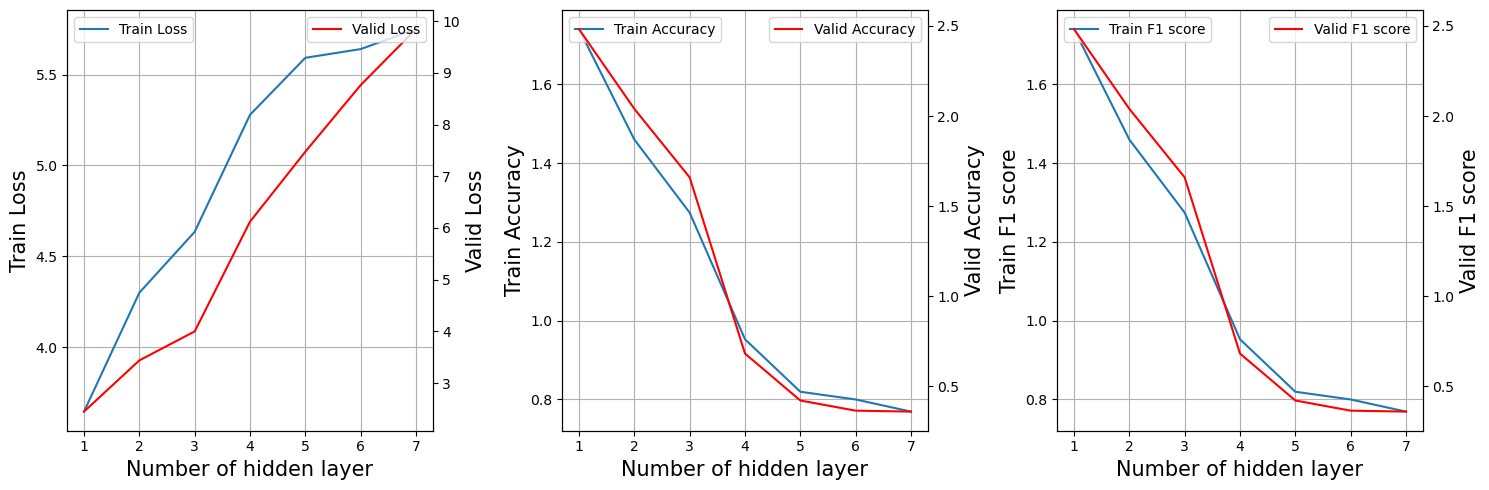

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(1, 8))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(1, 8))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(7))
axes[2].set_xticklabels(np.arange(1, 8))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

- 첫번째 은닉층을 기준으로 퍼셉트론 수 감소

In [86]:
layer_list2 = [[2**(10-j) for j in range(i+1)] for i in range(7)]
layer_list2

[[1024],
 [1024, 512],
 [1024, 512, 256],
 [1024, 512, 256, 128],
 [1024, 512, 256, 128, 64],
 [1024, 512, 256, 128, 64, 32],
 [1024, 512, 256, 128, 64, 32, 16]]

In [92]:
layer_list2 = [[2**(10-j) for j in range(i+1)] for i in range(7)]

loss_list = [[], []]
acc_list = [[], []]
f1_score_list = [[], []]

EPOCHS = 30
for layer in layer_list2:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    for _, modelList in model.named_children():
        for child in modelList:
            if isinstance(child, nn.Linear):
                nn.init.kaiming_normal_(child.weight)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model4/my_model2.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list[0].append(train_['loss'][-1])
    loss_list[1].append(val_['loss'][-1])
    acc_list[0].append(train_['acc'][-1])
    acc_list[1].append(val_['acc'][-1])
    f1_score_list[0].append(train_['f1'][-1])
    f1_score_list[1].append(val_['f1'][-1])

    print("Done!")

[Epoch 1/30] ....
[1 Train ] Loss ==> 4.869 Acc ==> 1.513 F1 ==> 1.513
[1 Valid ] Loss ==> 2.886 Acc ==> 2.176 F1 ==> 2.176

[Epoch 2/30] ....
[2 Train ] Loss ==> 3.569 Acc ==> 1.895 F1 ==> 1.895
[2 Valid ] Loss ==> 2.641 Acc ==> 2.269 F1 ==> 2.269

[Epoch 3/30] ....
[3 Train ] Loss ==> 3.117 Acc ==> 2.077 F1 ==> 2.077
[3 Valid ] Loss ==> 2.381 Acc ==> 2.345 F1 ==> 2.345

[Epoch 4/30] ....
[4 Train ] Loss ==> 2.803 Acc ==> 2.180 F1 ==> 2.180
[4 Valid ] Loss ==> 1.915 Acc ==> 2.595 F1 ==> 2.595

[Epoch 5/30] ....
[5 Train ] Loss ==> 2.578 Acc ==> 2.249 F1 ==> 2.249
[5 Valid ] Loss ==> 1.781 Acc ==> 2.638 F1 ==> 2.638

[Epoch 6/30] ....
[6 Train ] Loss ==> 2.367 Acc ==> 2.370 F1 ==> 2.370
[6 Valid ] Loss ==> 1.601 Acc ==> 2.690 F1 ==> 2.690

[Epoch 7/30] ....
[7 Train ] Loss ==> 2.246 Acc ==> 2.396 F1 ==> 2.396
[7 Valid ] Loss ==> 1.554 Acc ==> 2.686 F1 ==> 2.686

[Epoch 8/30] ....
[8 Train ] Loss ==> 1.996 Acc ==> 2.500 F1 ==> 2.500
[8 Valid ] Loss ==> 1.452 Acc ==> 2.727 F1 ==> 2.727



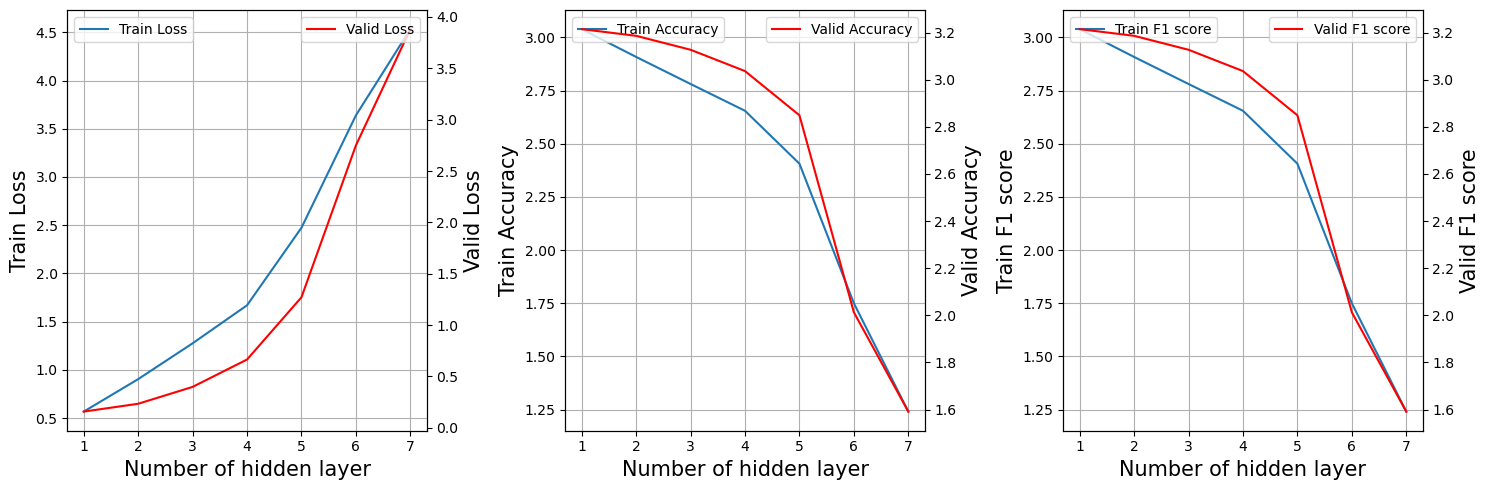

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(1, 8))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(1, 8))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(7))
axes[2].set_xticklabels(np.arange(1, 8))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

#### Orthogonal Initialization

In [ ]:
class FishModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, nodes_list = []):
        super().__init__()
        nodes_list.insert(0, in_dim)
        nodes_list.append(out_dim)
        layer_num = len(nodes_list) - 1
        layers = []
        for i in range(layer_num):
            if i <= layer_num - 2:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
                layers.append(nn.BatchNorm1d(num_features = nodes_list[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout())    
            else:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
        
        self.layers = nn.ModuleList(layers)

        nn.init.orthogonal_(self.layers[0].weight)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

- 첫번째 은닉층을 기준으로 퍼셉트론 수 증가

In [88]:
layer_list1 = [[2**(j+4) for j in range(i+1)] for i in range(7)]

loss_list = [[], []]
acc_list = [[], []]
f1_score_list = [[], []]

EPOCHS = 30
for layer in layer_list1:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    for _, modelList in model.named_children():
        for child in modelList:
            if isinstance(child, nn.Linear):
                nn.init.orthogonal_(child.weight)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
    
    print(f'IN : {IN_DIM}, OUT : {OUT_DIM}')

    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model4/my_model3.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list[0].append(train_['loss'][-1])
    loss_list[1].append(val_['loss'][-1])
    acc_list[0].append(train_['acc'][-1])
    acc_list[1].append(val_['acc'][-1])
    f1_score_list[0].append(train_['f1'][-1])
    f1_score_list[1].append(val_['f1'][-1])

    print("Done!")

IN : 2655, OUT : 9
[Epoch 1/30] ....
[1 Train ] Loss ==> 6.107 Acc ==> 0.940 F1 ==> 0.940
[1 Valid ] Loss ==> 4.837 Acc ==> 1.643 F1 ==> 1.643

[Epoch 2/30] ....
[2 Train ] Loss ==> 5.303 Acc ==> 1.193 F1 ==> 1.193
[2 Valid ] Loss ==> 4.452 Acc ==> 1.745 F1 ==> 1.745

[Epoch 3/30] ....
[3 Train ] Loss ==> 4.984 Acc ==> 1.285 F1 ==> 1.285
[3 Valid ] Loss ==> 4.165 Acc ==> 1.865 F1 ==> 1.865

[Epoch 4/30] ....
[4 Train ] Loss ==> 4.816 Acc ==> 1.340 F1 ==> 1.340
[4 Valid ] Loss ==> 4.041 Acc ==> 1.949 F1 ==> 1.949

[Epoch 5/30] ....
[5 Train ] Loss ==> 4.701 Acc ==> 1.383 F1 ==> 1.383
[5 Valid ] Loss ==> 3.876 Acc ==> 2.010 F1 ==> 2.010

[Epoch 6/30] ....
[6 Train ] Loss ==> 4.610 Acc ==> 1.419 F1 ==> 1.419
[6 Valid ] Loss ==> 3.760 Acc ==> 2.028 F1 ==> 2.028

[Epoch 7/30] ....
[7 Train ] Loss ==> 4.524 Acc ==> 1.451 F1 ==> 1.451
[7 Valid ] Loss ==> 3.620 Acc ==> 2.046 F1 ==> 2.046

[Epoch 8/30] ....
[8 Train ] Loss ==> 4.443 Acc ==> 1.475 F1 ==> 1.475
[8 Valid ] Loss ==> 3.500 Acc ==> 2

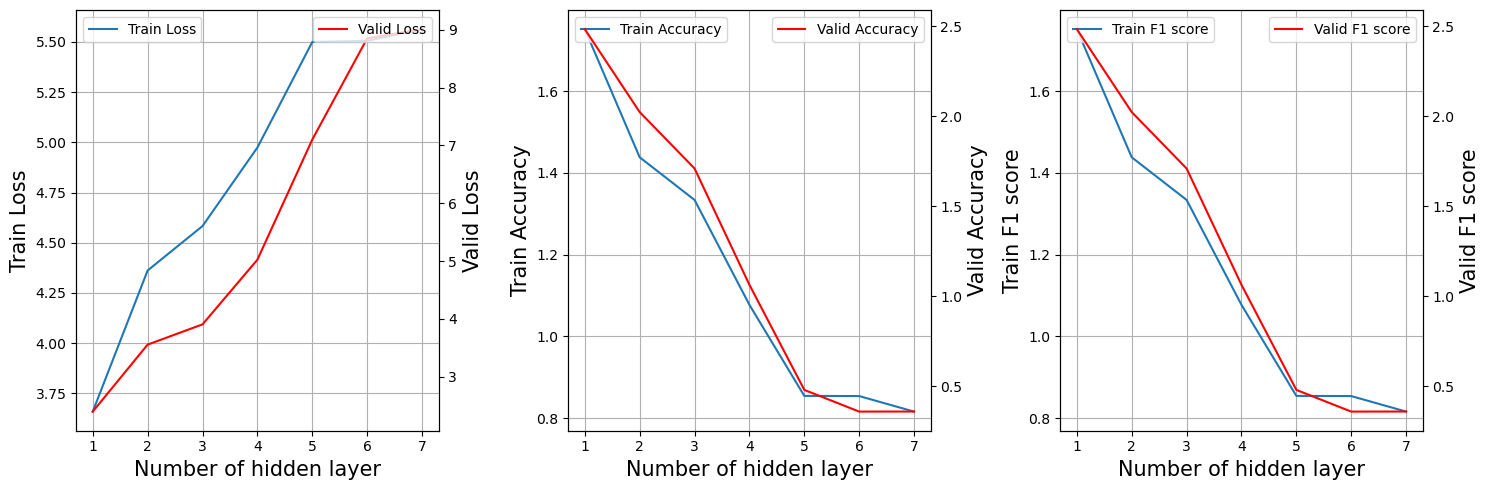

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(1, 8))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(1, 8))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(7))
axes[2].set_xticklabels(np.arange(1, 8))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

- 첫번째 은닉층을 기준으로 퍼셉트론 수 감소

In [90]:
layer_list2 = [[2**(10-j) for j in range(i+1)] for i in range(7)]

loss_list = [[], []]
acc_list = [[], []]
f1_score_list = [[], []]

EPOCHS = 30
for layer in layer_list2:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    for _, modelList in model.named_children():
        for child in modelList:
            if isinstance(child, nn.Linear):
                nn.init.orthogonal_(child.weight)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model4/my_model4.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list[0].append(train_['loss'][-1])
    loss_list[1].append(val_['loss'][-1])
    acc_list[0].append(train_['acc'][-1])
    acc_list[1].append(val_['acc'][-1])
    f1_score_list[0].append(train_['f1'][-1])
    f1_score_list[1].append(val_['f1'][-1])

    print("Done!")

[Epoch 1/30] ....
[1 Train ] Loss ==> 4.466 Acc ==> 1.539 F1 ==> 1.539
[1 Valid ] Loss ==> 2.977 Acc ==> 2.080 F1 ==> 2.080

[Epoch 2/30] ....
[2 Train ] Loss ==> 3.433 Acc ==> 1.898 F1 ==> 1.898
[2 Valid ] Loss ==> 2.574 Acc ==> 2.264 F1 ==> 2.264

[Epoch 3/30] ....
[3 Train ] Loss ==> 3.069 Acc ==> 2.050 F1 ==> 2.050
[3 Valid ] Loss ==> 2.241 Acc ==> 2.439 F1 ==> 2.439

[Epoch 4/30] ....
[4 Train ] Loss ==> 2.785 Acc ==> 2.193 F1 ==> 2.193
[4 Valid ] Loss ==> 2.025 Acc ==> 2.524 F1 ==> 2.524

[Epoch 5/30] ....
[5 Train ] Loss ==> 2.626 Acc ==> 2.249 F1 ==> 2.249
[5 Valid ] Loss ==> 1.902 Acc ==> 2.553 F1 ==> 2.553

[Epoch 6/30] ....
[6 Train ] Loss ==> 2.412 Acc ==> 2.336 F1 ==> 2.336
[6 Valid ] Loss ==> 1.649 Acc ==> 2.665 F1 ==> 2.665

[Epoch 7/30] ....
[7 Train ] Loss ==> 2.142 Acc ==> 2.431 F1 ==> 2.431
[7 Valid ] Loss ==> 1.517 Acc ==> 2.751 F1 ==> 2.751

[Epoch 8/30] ....
[8 Train ] Loss ==> 2.075 Acc ==> 2.470 F1 ==> 2.470
[8 Valid ] Loss ==> 1.394 Acc ==> 2.765 F1 ==> 2.765



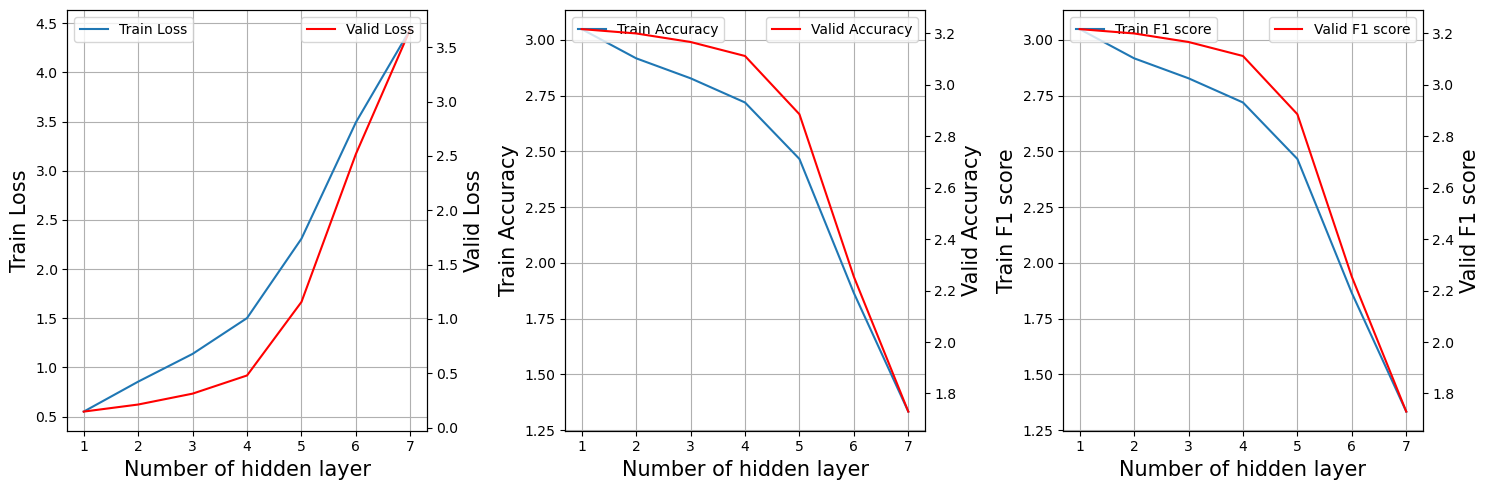

In [91]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(1, 8))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(1, 8))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(7))
axes[2].set_xticklabels(np.arange(1, 8))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()